## Работа с данными по медицинским страховкам в США. 

Цель работы : Проанализировать имеющиеся данные и сделать предсказание стоимости страховки, с помощью машинного обучения на основе модели линейной регрессии.

Задачи работы:

        1) Изучить имеющиеся у нас данные.
        2) Визуализировать признаки с целью их более подробного анализа.
        3) Изменить тип признаков, для дальнейшей работы.
        4) Провести корреляционный анализ.
        5) Подтвердить или опровергнуть гипотезу.*
        6) Подготовить данные для машинного обучения с учителем.
        7) Протестировать 2е выбранные модели.
        8) Оценить эффективность работы модели с помощью R2.
        9) Выбрать лучшую модель, по результатам оценки показателей.
        10) Поработать с параметрами выбранной модели, с целью улучшения ее предсказаний.
        11) Сделать предсказание на более настроенной модели.
        12) Сравнить показатели у одной и той же модели до настройки и после. 
        13) Визуализировать получившиеся результаты.
        14) Резюмировать проделанную работу. 
        
*Гипотеза Но : У людей находящихся в одной возрастной выборке цена страховки будет разная, если человек курит страховка будет дороже по отношению к человеку, той же возрастной группы, но не курящему. 

Гипотеза H1:Цена страховки для людей в одной возрастной группе будет одинаковой вне зависимости от того курит ли человек

Набор данных Insurance.csv содержит 1338 наблюдений (строки) и 7 признаков (столбцы). 

    age -  возраст
    sex - пол
    bmi - Индекс массы тела
    children - есть ли дети 
    smoker - курит или нет
    region - регион проживания
    expenses - цена страховки 

Дополнительная информация:
Данные по страховке США соответственно категорию ИМТ будем брать тоже США:

    Нормальный (18,5–24)
    Избыточная масса тела (25–29)
    Ожирение: класс I (30–34)
    Ожирение: класс II (35–39)
    Ожирение: класс III (≥ 40)


In [29]:
# Импартируем необходимые для работы библиотеки и функции:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score as r2
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

import random
import warnings
from colorama import Fore, Back, Style
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')

In [30]:
# Функция для построения финальных графиков и визуализации результатов(сосле ML).
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print('Train R2:\t' + str(round(r2(train_true_values, train_pred_values), 3)))
    print('Test R2:\t' + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    plt.show()

In [31]:
# Функция для кроссвалидации
def cross_val(X_train, y_train, model):
    accuracy = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    return accuracy.mean()

# Изучим наши данные :

In [4]:
# Загружаем наш df с данными по страховкам в США
df = pd.read_csv('/Users/User/Desktop/insurance.csv')

In [5]:
# Посмотрим по нему информацию:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 57.6+ KB


В нашем df 4 числовых признака и 3 объектных, впоследствии объектные я превращу в числовые, для удобства работы и последующего машинного обучения.

In [6]:
# Просматривая информацию по нашему df, мы видим что в нем нет пропусков, также это можно проверить с помощью:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [7]:
# Посмотрим первие 15 строк нашего df
df.head(15)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
5,31,female,25.7,0,no,southeast,3756.62
6,46,female,33.4,1,no,southeast,8240.59
7,37,female,27.7,3,no,northwest,7281.51
8,37,male,29.8,2,no,northeast,6406.41
9,60,female,25.8,0,no,northwest,28923.14


In [8]:
# Посмотрим количественные показатели нашего df
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


Изучив имеющиеся у нас данные мы видим, что они не имеют пропусков, что хорошо, т.к линейная регрессия не работает с пропусками.
Если бы они были их нужно былобы или корректно заполнить стараясь максимально не исказить картину (что не всегда возможно) или удалить (что в нашем случае нерационально, так как данных у нас не так много всего 1338 в общей выборке).
Также стоит обратить внимание, что данные, на первый взгляд, распределены хорошо об этом нам говорит распределение их по  квартилям. Минимальные, максимальные и средние показатели тоже в пределах нормы.

# Визуализируем признаки:

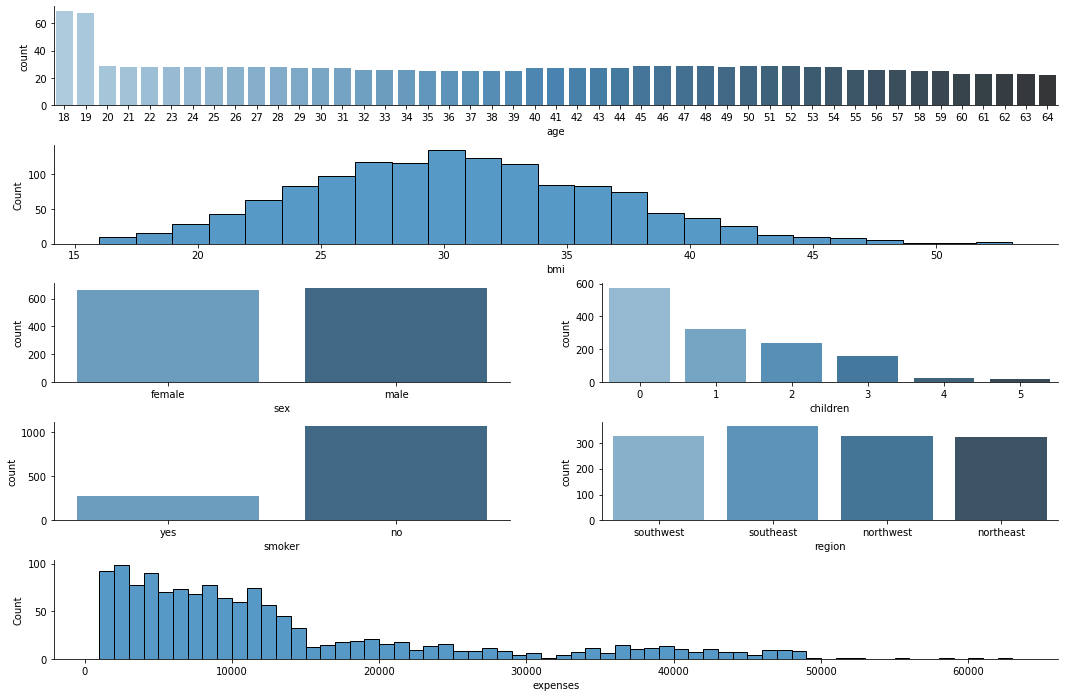

In [9]:
# Строим графики и располагаем их на координатной сетке так, чтобы они хорошо читались.
fig = plt.figure(figsize = (18, 12))
gs = fig.add_gridspec(5, 2) 
ax = [None for _ in range(7)]

ax[0] = plt.subplot2grid((5,2), (0,0), colspan=2) 
sns.countplot(df['age'], palette="Blues_d")
sns.despine(top=True, right=True)

ax[1] = plt.subplot2grid((5,2), (1,0), colspan=2) 
sns.histplot(df['bmi'])
sns.despine(top=True, right=True)


ax[2] = plt.subplot2grid((5,2), (2,0), colspan=1)
sns.countplot(df['sex'], palette="Blues_d")
sns.despine(top=True, right=True)

ax[3] = plt.subplot2grid((5,2), (2,1), colspan=1)
sns.countplot(df['children'], palette="Blues_d")
sns.despine(top=True, right=True)

ax[4] = plt.subplot2grid((5,2), (3,0), colspan=1) 
sns.countplot(df['smoker'], palette="Blues_d")
sns.despine(top=True, right=True)

ax[5] = plt.subplot2grid((5,2), (3,1), colspan=1)   
sns.countplot(df['region'], palette="Blues_d") 
sns.despine(top=True, right=True)

ax[6] = plt.subplot2grid((5,2), (4,0), colspan=2) 
sns.histplot(df['expenses'],bins=np.arange(1000, 64000, 1000))
sns.despine(top=True, right=True)

plt.subplots_adjust(wspace=0.2, hspace=0.4)


plt.show()

На графиках хорошо видно, что:

    1) Нормальное распределение (распределением Гаусса или Гаусса — Лапласа) имеют только данные по показателю индекса массы тела, т.к. мы хорошо видим куполообразное распределение, что характерно именно для нормального распределения данных. Функция задающая нормальное распределение это функция плотности вероятности которая совпадает с функцией Гаусса и выражается формулой :
    {\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}}

    2) Количество мужчин и женщин в наших данных почти одинаковое.
    3) В нашем df преобладают некурящие люди.
    4) Большинство людей не имеют детей
    5) Много представителей 18 и 19 лет , далее возраста распределяются более менее ровно, без скачков и коллебаний.
    6) Распределение по районам тоже почти пропорционально одинаковое.
    7) На графике такого показателя как цена страховки, хорошо виден "хвост" , что не очень хорошо, это может сказываться на финальных предсказаниях цены.

# Меняем признаки на числовые: 

In [10]:
df['region'] = df['region'].astype('category')

In [11]:
smoker = {'no' : 0,
             'yes' : 1}

df= df.replace({'smoker': smoker})

In [12]:
sex = {'female' : 0,
             'male' : 1}

df= df.replace({'sex': sex})

Закодируем получившийся категориальный признак район с помощью класса `OneHotEncoder`, данный метод из одного категориального признака делает несколько бинарных признаков по количеству различных значений исходного категориального признака. Использую именно этот способ, чтобы избежать перекоса в весе признака.

In [13]:
ohe = OneHotEncoder()
X = ohe.fit_transform(df.region.values.reshape(-1,1)).toarray()
OHE = pd.DataFrame(X, columns = ["northeast","northwest","southeast","southwest"])
df = pd.concat([df, OHE], axis=1)
df = df.drop("region",axis = 1)

# Корреляция


Корреляционный анализ — метод обработки статистических данных, благодаря которому можно определить тесноту связи между несколькими показателями. Корреляционный анализ имеет тесную связь с регрессионным. Такой анализ принято называть корреляционно-регрессионным — используя его, можно определять включение и исключение показателей в уравнение множественной регрессии. А применяя коэффициент детерминации — проводить оценку полученного уравнение регрессии на соответствие выявленным связям.
Корреляционный анализ применяется для оценки степени линейной зависимости между парами факторов (принимает значения от -1 до 1, чем ближе его значение к 0, тем слабее линейная зависимость, а чем ближе к 1 тем сильнее), если модуль коэффициента корреляции больше 0,6, то линейная зависимость сильная, а если менее 0,3, то почти отсутствует. 

Формула расчет коэффициента корреляции Пирсона:

r_{xy}=\frac{\Sigma(x_i-\bar{x})\times(y_i-\bar{y})}{\sqrt{\Sigma(x_i-\bar{x})^2\times\Sigma(y_i-\bar{y})^2}}

Стоит заметить, что низкая степень корреляции между входным и прогнозируемым полями не означает отсутствие других, нелинейных зависимостей. Кроме того, при построении линейных моделей стоит рассмотреть такой входной фактор внимательнее, так как он может быть использован для проектирования признаков (Feature Engineering).
Такой анализ не всегда можно сделать, если выборка маленькая его не получится провести, наш объем данных позволяет нам его сделать: 

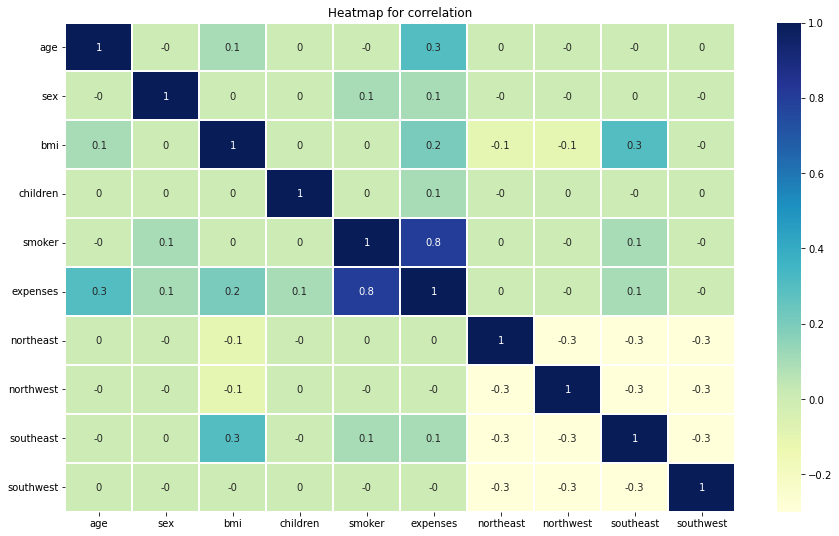

In [14]:
#Для анализа корреляции признаков можно использовать только функцию df.corr(), но на мой взгляд на графике значительно нагляднее, 
#хотя используя функцию мы получим тоже самое, но в менее удобном виде.

correlation = df.corr()

fig,ax = plt.subplots(figsize=(15,9))
plt.title("Heatmap for correlation")
sns.heatmap(correlation.round(1),cmap='YlGnBu',annot=True,linewidth=0.30,ax=ax)
plt.show()

Как мы видим из графика корреляции, самая сильная корреляционная связь между тем курит ли человек и ценой.Также корреляцию
показывает возраст к цене и индекс массы тела, но эта корреляция статистически не значимая.
Фактически к статистически значимой корреляции мы можем отнести только корреляцию между ценой и курением, т.к. она выше 0.6.
Такая высокая корреляция может негативно сказываться на обучении модели с помощью LR и в сущности его нужно убрать, чего мы не можем себе позволить, так как в наших данных это очень важный параметр и для анализа и для предсказаний, попробуем впоследствии нивелировать ущерб с помощью настроек модели.

# Подтверждение гипотизы

Сгупперуем интересующие нас данные, что бы убедится в правильности гипотезы Но.
Для этого я возьму такие показатели как:

    1) Среднее значение(mean) из датасета с нужными нам параметрами группировки. Считается по формуле: M(X)=1n∑i=1nxi
    2) Среднее квадратичное отклонение(std) показывает, насколько далеко наблюдения могут быть «разбросаны» относительно среднего значения.Вычислить его можно по формуле: STD=√[(∑(x-x)2)/n]
    3) Медиана (median) это значение, которое делит данные на две равные части. 

In [15]:
# Группируем такие показатели как возраст и курение и выведим по ним среднее, медиану и стандартное квадратичное отклонение.
df1 = df.groupby(by=['age', 'smoker'])['expenses'].agg(['mean','std', 'median'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 4,
                       ):
    print(df1)

                  mean         std     median
age smoker                                   
18  0        3215.1626   3963.2625   1712.230
    1       25473.7308  10793.9818  25978.070
19  0        3536.7132   5597.1936   1746.620
    1       27001.2333   9687.9256  32927.945
20  0        3673.1130   5734.8041   2120.965
    1       24574.3311   9545.9080  20167.340
21  0        3813.5304   5358.5015   2103.595
    1       16650.6050   1826.4639  16650.605
22  0        2551.0177    747.6244   2252.820
    1       37373.2883   3721.1048  36380.375
23  0        5980.9786   6478.6650   2789.060
    1       31736.3457   9500.6695  36021.010
24  0        5587.4300   6539.7184   2846.720
    1       29203.4967   9936.9481  34363.445
25  0        5547.1874   5760.0388   3238.440
    1       29577.7820  11191.5714  33900.650
26  0        4166.5168   4311.6267   3378.910
    1       22528.0667  11811.9157  17043.340
27  0        5800.9763   5562.5999   3578.000
    1       25661.4544  10515.0711

Посмотрим среднюю разницу цены страховки курящих и некурящих людей одной возрастной категории.
Для этого мы вычтим среднюю стоимость страховки не курящих людей из средней стоимости страховки курящих людей. 
Для получения процентного соотношения мы среднюю стоимость страховки курящих людей разделим на среднюю стоимость страховки не курящих людей и умножим на 100.

In [16]:
df2 = df.groupby(by=['age', 'smoker'])['expenses'].agg(['mean'])
df2 = df2.pivot_table(index='age', columns='smoker')
df2['difference']= (df2.iloc[:,1] - df2.iloc[:,0]).round(4)
df2['difference %']= (df2.iloc[:,1] / df2.iloc[:,0] * 100).round(4)
df2

mean                difference difference %
smoker             0             1                         
age                                                        
18       3215.162632  25473.730833  22258.5682     792.2999
19       3536.713200  27001.233333  23464.5201     763.4556
20       3673.113000  24574.331111  20901.2181     669.0328
21       3813.530385  16650.605000  12837.0746     436.6192
22       2551.017727  37373.288333  34822.2706    1465.0344
23       5980.978571  31736.345714  25755.3671     530.6213
24       5587.430000  29203.496667  23616.0667     522.6642
25       5547.187391  29577.782000  24030.5946     533.2032
26       4166.516800  22528.066667  18361.5499     540.6930
27       5800.976316  25661.454444  19860.4781     442.3644
28       6016.296000  34509.950000  28493.6540     573.6079
29       6324.361429  24800.453333  18476.0919     392.1416
30       5266.642778  27624.047778  22357.4050     524.5096
31       4579.078182  34915.748000  30336.6698     762.5060
32       5271.313810  25806.040000  20534.7262     489.5561
33       6846.030500  30703.205000  23857.1745     448.4819
34       6944.390952  31223.906000  24279.5150     449.6277
35       7117.046500  28067.730000  20950.6835     394.3733
36       5637.341053  33000.410000  27363.0689     585.3896
37       7995.078125  35841.837778  27846.7597     448.2988
38       6295.581739  28884.970000  22589.3883     458.8134
39       7893.446842  24080.100000  16186.6532     305.0644
40       8171.216818  27616.804000  19445.5872     337.9766
41       7231.202800  39935.530000  32704.3272     552.2668
42       7025.589474  27395.230000  20369.6405     389.9350
43       9559.486000  31402.021667  21842.5357     328.4907
44       9142.108571  39369.906667  30227.7981     430.6436
45       9534.540417  40249.362000  30714.8216     422.1427
46       9317.205833  38464.442000  29147.2362     412.8324
47      10405.286842  31426.554000  21021.2672     302.0249
48      11195.560000  31129.812000  19934.2520     278.0550
49      10189.160833  27737.077500  17547.9167     272.2214
50      12153.349200  37598.340000  25444.9908     309.3661
51       9819.143913  38157.516667  28338.3728     388.6033
52      14100.958696  34184.965000  20084.0063     242.4301
53      12580.704348  31845.970000  19265.2657     253.1334
54      13099.005217  44792.436000  31693.4308     341.9530
55      13897.945000  43363.745000  29465.8000     312.0155
56      11563.928636  34064.257500  22500.3289     294.5734
57      12755.455909  36751.702500  23996.2466     288.1254
58      12478.196250  47496.490000  35018.2938     380.6359
59      15222.189524  38182.690000  22960.5005     250.8357
60      14719.411111  48115.448000  33396.0369     326.8843
61      16181.750588  38578.793333  22397.0427     238.4093
62      15391.066316  37084.607500  21693.5412     240.9489
63      14205.336111  40331.786000  26126.4499     283.9200
64      15805.351333  39283.058571  23477.7072     248.5428

Получившиеся данные наглядно демонстрируют и доказывают, что у людей находящихся в одной возрастной категории в зависимости от курения цена страховки будет очень разной.
У курящих людей, в среднем страховка значительно дороже, о чем нам говорят среднии значения по группам и  
среднеквадратичное отклонение случайной величины (x) относительно ее математического ожидания на основе несмещенной
оценки ее дисперсии у курильщиков выше, что говорит о сильной волатильность данных(как сильно показатель цены колеблется). 

# Выбросы

Выбросы это это все, что выше Q3 + 1,5*IQR или ниже Q1 – 1,5*IQR

Q3 - это третий квартиль или 75% процентиль
IQR(межквартильный размах) — это разница между 75-м процентилем (Q3) и 25-м процентилем (Q1). Он измеряет разброс 
средних 50% значений.
По формуле их можно определить так: выбросы = наблюдения > Q3 + 1,5*IQR или Q1 – 1,5*IQR 

Для этих целий отлично подходит график boxplot или как его еще "называют ящик с усами".

Посмотрим есть ли у нас выбросы (возьмем соотношение возраста к цене):

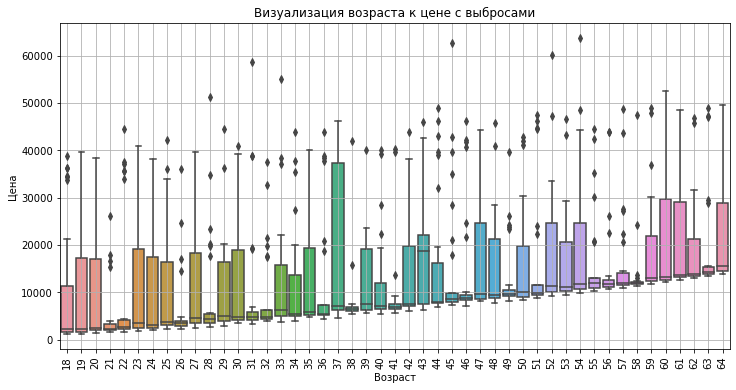

In [17]:
plt.subplots(figsize=(12,6))
sns.boxplot(x="age",y="expenses",data=df)
plt.xticks(rotation=90)
plt.ylabel('Цена')
plt.xlabel('Возраст')
plt.title('Визуализация возраста к цене c выбросами')
plt.grid()

Из этого графика мы видим, что у нас присутствуют выбросы, но судя по цифрам этими "выбрасами" являются цены на страховку курящих людей.

Давайте это проверим, для этого мы так же возьмем график boxplot, но дабавим еще парамерт:

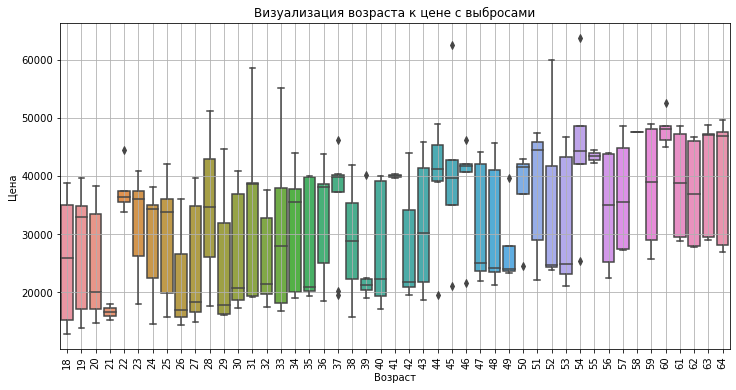

In [18]:
plt.subplots(figsize=(12,6))
sns.boxplot(x="age",y="expenses",data=df.loc[df['smoker']==1])
plt.xticks(rotation=90)

plt.ylabel('Цена')
plt.xlabel('Возраст')
plt.title('Визуализация возраста к цене с выбросами')
plt.grid()

Да, в сущности так и оказалось, этими выбросами оказались цены на страховку курящих людей, которая как мы уже успели убедиться значительно дороже, страховки некурящих людей. И отрезав эти "выбросы", мы могли бы лишится важных данных, не говоря уже о том что в нашем df и без того преобладают некурящие люди, на фоне чего лишится данных о курящих людях будет нерационально. 
По статистически значимыу показателю выбросов мало и несмотря на то, что модели линейной регрессии чувствительны к выбросам, такое их количество не должно  значимо сказываться на результатах.

# Подгатовка данных к машинному обучению 

Перейдем к подготовке данных для машинного обучения. 
Методы линейной регрессии  не требует масштабирования признаков, мы не будем их делать, после выбора более предпочтительной нам модели (между LinearRegression(LR)  и GradientBoostingRegressor(GB))  мы используем кросс валидацию для подбора параметров, с целью улучшения результатов.

In [19]:
df.columns.tolist() #создаем список из имеющихся у нас параметров

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'expenses',
 'northeast',
 'northwest',
 'southeast',
 'southwest']

In [20]:
# Присваеваем наши параметры переменным
X = df[['age','sex','bmi','children','smoker','northeast','northwest','southeast','southwest']] 
y = df['expenses']

In [21]:
# Разбиваем данные на тестовые и тренировачные 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

# Машинное обучение

Мы будем использовать машинное обучение с учителем. 
Попробуем 2е модели:

    1) LinearRegression(LR). Базовая модель машинного обучения. Линейная регрессия — используемая в статистике регрессионная модель зависимости одной переменной y от другой или нескольких других переменных x с линейной функцией зависимости. Математическое уравнение, которое оценивает линию простой (парной) линейной регрессии:Y=a+bx.
    Где:
    x называется независимой переменной или предиктором.
    Y – зависимая переменная или переменная отклика. Это значение, которое мы ожидаем для y (в среднем), если мы знаем величину x, т.е. это «предсказанное значение y»Парную линейную регрессию можно расширить, включив в нее более одной независимой переменной; в этом случае она известна как множественная регрессия.
    
    2)GradientBoostingRegressor (GB).Он тоже идет из класса линейных моделей машинного обучения, но является более продвинутым алгоритмом машинного обучения. Используется  для решения задач регрессии.  Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений. Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную. Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом, что каждая последующая модель сводит ошибку предыдущей к минимуму.
    
Оценивать эффективность моделей мы будем с помощью R2. 

Оценка R2 – это один из показателей оценки эффективности моделей машинного обучения на основе регрессии, также известна как коэффициент детерминации. Работает на основе измерении количества отклонений в прогнозах, объясненных набором данных (разница между выборками в наборе данных и прогнозами, сделанными моделью). Результативность варьируется от 0 до 1,чем получившийся показатель ближе к 1 тем лучше обучалась модель и более точными будут предсказания. Посчитать его можно как квадрат коэффициента корреляции:R^2 = r^{2}_{xy}

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

Train R2:	0.762
Test R2:	0.724


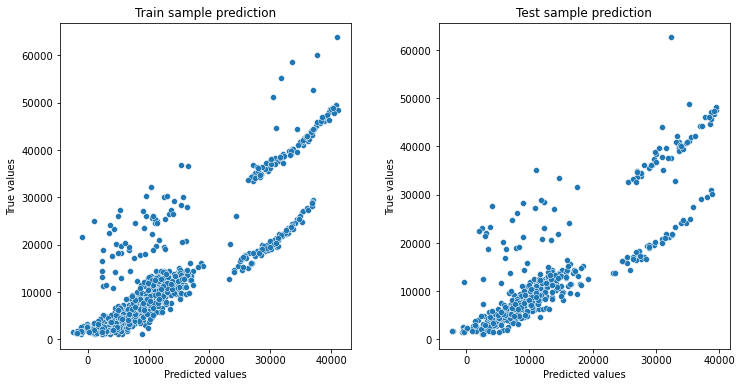

In [23]:
lr_y_train_preds = lr_model.predict(X_train)
lr_y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_train, lr_y_train_preds, y_test, lr_y_test_preds)

In [24]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

Train R2:	0.919
Test R2:	0.824


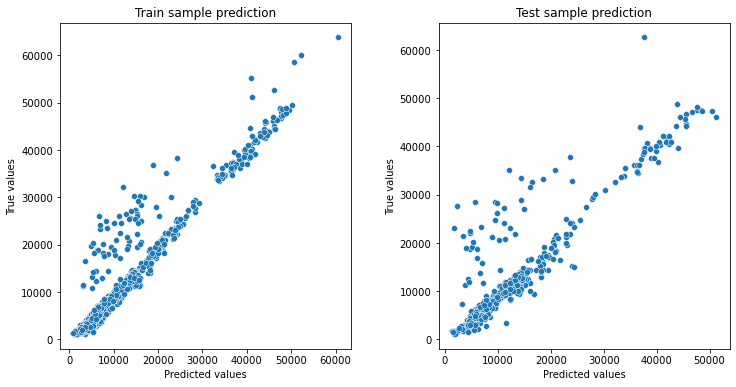

In [25]:
gb_y_train_preds = gb_model.predict(X_train)
gb_y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_train, gb_y_train_preds, y_test, gb_y_test_preds)

Мы видим, что на обучающем множестве значения ошибок предсказания получились немного меньше, чем на тестовом множестве. Это и понятно, ведь наша модель так построена по обучающим данным, чтобы давать на них наименьшую ошибку. На данных, которые она "не видела" при обучении, она может вычислять предсказания несколько хуже. В этом и есть причина разделения данных на обучающую и тестовую часть.Как и предполагалось GB модель показывает более высокие результаты, сней и продолжим работать. 

In [35]:
# Подбор параметров:
param_dist = {"max_depth": [3, None],
              "min_samples_leaf": randint(1, 20),
              "loss" :['squared_error', 'absolute_error', 'huber', 'quantile'],
             "n_estimators": randint(1,200),
             "criterion": ['friedman_mse', 'squared_error']} # создаем словарь с диап. пораметров.

new_gb = GradientBoostingRegressor() # создаем новую пустую модель

cv_gb = RandomizedSearchCV(new_gb, param_dist, cv=50, random_state=42) # создаем "коросс валидатор" указывая модель и возможные параметры.

cv_gb.fit(X_train, y_train) # проводим кросс валидацию

print("Лучшие параметры: {}".format(cv_gb.best_params_)) # печатаем рекомендованные параметры
print("Лучший рейтинг {}".format(cv_gb.best_score_)) # печатаем лучший рейтинг из всех вариаций модели

Лучшие параметры: {'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 11, 'n_estimators': 88}
Лучший рейтинг 0.8322859311796393


In [36]:
tuned_gb = GradientBoostingRegressor(criterion = 'friedman_mse', loss = 'huber', max_depth = 3, min_samples_leaf = 11, 
                                     n_estimators = 88) # создаем новую модель с новыми параметрами
tuned_gb.fit(X_train, y_train) # подаем наши данные 

GradientBoostingRegressor(loss='huber', min_samples_leaf=11, n_estimators=88)

Train R2:	0.878
Test R2:	0.83


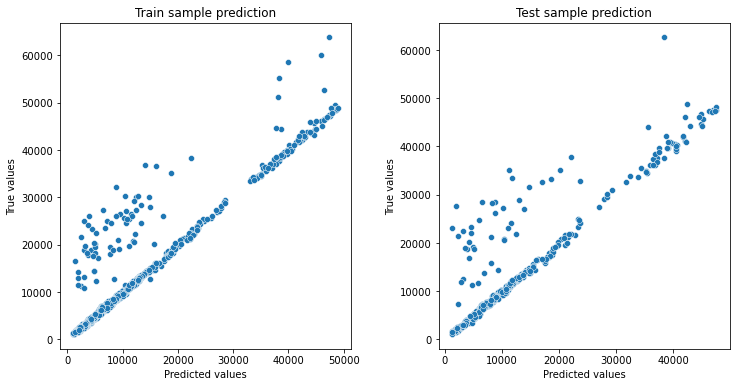

In [37]:
gb_y_train_preds_new = tuned_gb.predict(X_train) # предсказываем на новых параметрах на обученной модели 
gb_y_test_preds_new = tuned_gb.predict(X_test) # предсказываем на новых параметрах на обученной модели 
evaluate_preds(y_train, gb_y_train_preds_new, y_test, gb_y_test_preds_new) # проверяем результат 

Резюме из проделанной работы:

На первый взгляд кажущиеся хорошими данные впоследствии все же преподнесли сюрпризы. Несмотря на отсутствие пропусков в наших данных присутствуют выбросы, что негативно сказывается на точности предсказаний, т.к. все модели машинного обучения класса линейной регрессии к ним чувствительны. Распределение данных тоже нельзя назвать благоприятным, т.к. нормальное распределение показал только лишь критерий индекса массы тела. Также стоит обратить внимание на то, что "хвост" в цене страховки в итоге отражается на точности предсказания, это хорошо прослеживается на графике.
Корреляционная связь в нашей работе логична и объяснима. Чем больше факторов риска здоровью, тем выше цена страховки. Следовательно чем старше человек, чем больше у него индекс массы тела и присутствует ли фактор курения, тем у него будет выше стоимость страховки. Это пропорционально и взаимосвязано, увеличение рисков заболевания влечет за собой увеличение стоимости страховки. Несмотря на логичность, присутствующая в наших данных корреляция признаков равная 0.8, сильно сбивает общую картину и ухудшает точность предсказаний, но очень ярко демонстрирует и подтверждают гипотезу Hо.
Машинное обучение на GB дало хорошие результаты показатель R2 до дополнительных настроек модели показывал результат 0.919 на трейне и 0.824 на тесте, что довольно неплохо, учитывая наши не совсем чистые вводные, но при этом есть большой разрыв между показателем трейна и теста, что может свидетельствовать о том что модель переучивается. После добавления дополнительных параметров R2 удалось увеличить до 0.83 на тесте и мы видим что трейн уменьшился до 0.878, за счет чего ушел столь большой разрыв между выборками. Предсказания получились довольно точными. Цель работы успешно выполнена.